In [1]:
import tensorflow as tf

In [2]:
data_name = 'oxford_flowers102'

In [3]:
import tensorflow_datasets as tfds

(train,test,validation), info = tfds.load(
    data_name,
    split=['test','train','validation'],
    data_dir="dataset\\",
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    batch_size=-1
)

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [5]:
train_images,train_labels = tfds.as_numpy(train)
test_images,test_labels = tfds.as_numpy(test)
validation_images,validation_labels = tfds.as_numpy(validation)

In [6]:
import cv2
import numpy as np

def preprocessing(images,label):
    images_ = []
    
    for i in range(len(images)):
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224),interpolation = cv2.INTER_AREA)
        image = image/127.5-1.0
        image = image.astype('float16')
        
        images_.append(image)
        
    label = label.astype('uint16')
    images = np.array(images_)
    return images,label

In [7]:
train_images,train_labels = preprocessing(train_images,train_labels)
print(f"Train images shape:{train_images.shape}\nTrain labels shape:{train_labels.shape}")

Train images shape:(6149, 224, 224, 3)
Train labels shape:(6149,)


In [8]:
test_images,test_labels = preprocessing(test_images,test_labels)
print(f"Test images shape:{test_images.shape}\nTest labels shape:{test_labels.shape}")

Test images shape:(1020, 224, 224, 3)
Test labels shape:(1020,)


In [9]:
validation_images,validation_labels = preprocessing(validation_images,validation_labels)
print(f"Validation images shape:{validation_images.shape}\nValidation labels shape:{validation_labels.shape}")

Validation images shape:(1020, 224, 224, 3)
Validation labels shape:(1020,)


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(32)

validation_ds = tf.data.Dataset.from_tensor_slices((validation_images,validation_labels)).batch(32)

In [11]:
del train
del test
del validation
del train_images
del test_images
del validation_images
del train_labels
del test_labels
del validation_labels

In [12]:
class MyModel(tf.keras.models.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.block1_conv = tf.keras.layers.Conv2D(64, (7,7), strides = 2, padding = 'valid', activation=tf.keras.activations.relu)
        self.max_pool = tf.keras.layers.MaxPooling2D((3,3), strides = 2)
        self.block2_conv = tf.keras.layers.Conv2D(64, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.block3_conv = tf.keras.layers.Conv2D(192, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        
        self.gavr_pool = tf.keras.layers.AveragePooling2D((5,5),padding = 'valid',strides=1)
        self.dropout = tf.keras.layers.Dropout(0.4)
        self.hidden = tf.keras.layers.Dense(1000, activation = tf.keras.activations.relu)
        self.output_layer = tf.keras.layers.Dense(102, activation = tf.keras.activations.softmax)
        
        
        # classification1
        self.classification1_avr_pool = tf.keras.layers.AveragePooling2D((5,5), strides = 3)
        self.classification1_conv = tf.keras.layers.Conv2D(128, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.classification1_flatten = tf.keras.layers.Flatten()
        self.classification1_hidden1 = tf.keras.layers.Dense(1024, activation = tf.keras.activations.relu)
        self.classification1_dropout = tf.keras.layers.Dropout(0.7)
        self.classification1_output_layer = tf.keras.layers.Dense(102, activation = tf.keras.activations.softmax)
        
        
        # classification2
        self.classification2_avr_pool = tf.keras.layers.AveragePooling2D((5,5), strides = 3)
        self.classification2_conv = tf.keras.layers.Conv2D(128, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.classification2_flatten = tf.keras.layers.Flatten()
        self.classification2_hidden1 = tf.keras.layers.Dense(1024, activation = tf.keras.activations.relu)
        self.classification2_dropout = tf.keras.layers.Dropout(0.7)
        self.classification2_output_layer = tf.keras.layers.Dense(102, activation = tf.keras.activations.softmax)
        
        
        # inception1
        self.inception1_1_1 = tf.keras.layers.Conv2D(64,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception1_2_1 = tf.keras.layers.Conv2D(96, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception1_2_2 = tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception1_3_1 = tf.keras.layers.Conv2D(16, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception1_3_2 = tf.keras.layers.Conv2D(32, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception1_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception1_4_2 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
        
        # inception2
        self.inception2_1_1 = tf.keras.layers.Conv2D(128,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception2_2_1 = tf.keras.layers.Conv2D(128, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception2_2_2 = tf.keras.layers.Conv2D(192, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception2_3_1 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception2_3_2 = tf.keras.layers.Conv2D(96, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception2_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception2_4_2 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
        
        # inception3
        self.inception3_1_1 = tf.keras.layers.Conv2D(192,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception3_2_1 = tf.keras.layers.Conv2D(96, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception3_2_2 = tf.keras.layers.Conv2D(208, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception3_3_1 = tf.keras.layers.Conv2D(16, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception3_3_2 = tf.keras.layers.Conv2D(48, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception3_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception3_4_2 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
        
        # inception4
        self.inception4_1_1 = tf.keras.layers.Conv2D(160,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception4_2_1 = tf.keras.layers.Conv2D(112, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception4_2_2 = tf.keras.layers.Conv2D(224, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception4_3_1 = tf.keras.layers.Conv2D(24, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception4_3_2 = tf.keras.layers.Conv2D(64, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception4_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception4_4_2 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
        
        # inception5
        self.inception5_1_1 = tf.keras.layers.Conv2D(128,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception5_2_1 = tf.keras.layers.Conv2D(128, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception5_2_2 = tf.keras.layers.Conv2D(256, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception5_3_1 = tf.keras.layers.Conv2D(24, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception5_3_2 = tf.keras.layers.Conv2D(64, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception5_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception5_4_2 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
        
        # inception6
        self.inception6_1_1 = tf.keras.layers.Conv2D(112,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception6_2_1 = tf.keras.layers.Conv2D(144, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception6_2_2 = tf.keras.layers.Conv2D(288, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception6_3_1 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception6_3_2 = tf.keras.layers.Conv2D(64, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception6_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception6_4_2 = tf.keras.layers.Conv2D(64, (1,1), padding = 'same', activation = tf.keras.activations.relu)

        
        # inception7
        self.inception7_1_1 = tf.keras.layers.Conv2D(256,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception7_2_1 = tf.keras.layers.Conv2D(160, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception7_2_2 = tf.keras.layers.Conv2D(320, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception7_3_1 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception7_3_2 = tf.keras.layers.Conv2D(128, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception7_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception7_4_2 = tf.keras.layers.Conv2D(128, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
        
        # inception8
        self.inception8_1_1 = tf.keras.layers.Conv2D(256,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception8_2_1 = tf.keras.layers.Conv2D(160, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception8_2_2 = tf.keras.layers.Conv2D(320, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception8_3_1 = tf.keras.layers.Conv2D(32, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception8_3_2 = tf.keras.layers.Conv2D(128, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception8_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception8_4_2 = tf.keras.layers.Conv2D(128, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
        
        # inception9
        self.inception9_1_1 = tf.keras.layers.Conv2D(384,(1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception9_2_1 = tf.keras.layers.Conv2D(192, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception9_2_2 = tf.keras.layers.Conv2D(384, (3,3), padding = 'same', activation = tf.keras.activations.relu)
        self.inception9_3_1 = tf.keras.layers.Conv2D(48, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        self.inception9_3_2 = tf.keras.layers.Conv2D(128, (5,5), padding = 'same', activation = tf.keras.activations.relu)
        self.inception9_4_1 = tf.keras.layers.MaxPooling2D((3,3),strides=1, padding = 'same')
        self.inception9_4_2 = tf.keras.layers.Conv2D(128, (1,1), padding = 'same', activation = tf.keras.activations.relu)
        
    def call(self, x):
        
        x = self.block1_conv(x)
        x = self.max_pool(x)
        x = self.block2_conv(x)
        x = self.block3_conv(x)
        x = self.max_pool(x)
        
        # ----- inception block 1 ----- #
        inception1_out1 = self.inception1_1_1(x)
        
        inception1_out2 = self.inception1_2_1(x)
        inception1_out2 = self.inception1_2_2(inception1_out2)
        
        inception1_out3 = self.inception1_3_1(x)
        inception1_out3 = self.inception1_3_2(inception1_out3)
        
        inception1_out4 = self.inception1_4_1(x)
        inception1_out4 = self.inception1_4_2(inception1_out4)
        
        x = tf.keras.layers.Concatenate()([inception1_out1,inception1_out2,inception1_out3,inception1_out4])
        # - - - - - - - - - - - - - - - #

        # ----- inception block 2 ----- #
        inception2_out1 = self.inception2_1_1(x)
        
        inception2_out2 = self.inception2_2_1(x)
        inception2_out2 = self.inception2_2_2(inception2_out2)
        
        inception2_out3 = self.inception2_3_1(x)
        inception2_out3 = self.inception2_3_2(inception2_out3)
        
        inception2_out4 = self.inception2_4_1(x)
        inception2_out4 = self.inception2_4_2(inception2_out4)
        
        x = tf.keras.layers.Concatenate()([inception2_out1,inception2_out2,inception2_out3,inception2_out4])
        # - - - - - - - - - - - - - - - #
        
        x = self.max_pool(x)
        
        # ----- inception block 3 ----- #
        inception3_out1 = self.inception3_1_1(x)
        
        inception3_out2 = self.inception3_2_1(x)
        inception3_out2 = self.inception3_2_2(inception3_out2)

        inception3_out3 = self.inception3_3_1(x)
        inception3_out3 = self.inception3_3_2(inception3_out3)
        
        inception3_out4 = self.inception3_4_1(x)
        inception3_out4 = self.inception3_4_2(inception3_out4)
        
        x = tf.keras.layers.Concatenate()([inception3_out1,inception3_out2,inception3_out3,inception3_out4])
        # - - - - - - - - - - - - - - - #
        
        
        # classification block
        classification1 = self.classification1_avr_pool(x)
        classification1 = self.classification1_conv(classification1)
        classification1 = self.classification1_flatten(classification1)
        classification1 = self.classification1_hidden1(classification1)
        classification1 = self.classification1_dropout(classification1)
        classification1 = self.classification1_output_layer(classification1)
        
        
        # ----- inception block 4 ----- #
        inception4_out1 = self.inception4_1_1(x)
        
        inception4_out2 = self.inception4_2_1(x)
        inception4_out2 = self.inception4_2_2(inception4_out2)

        inception4_out3 = self.inception4_3_1(x)
        inception4_out3 = self.inception4_3_2(inception4_out3)
        
        inception4_out4 = self.inception4_4_1(x)
        inception4_out4 = self.inception4_4_2(inception4_out4)
        
        x = tf.keras.layers.Concatenate()([inception4_out1,inception4_out2,inception4_out3,inception4_out4])
        # - - - - - - - - - - - - - - - #
        
        
        # ----- inception block 5 ----- #
        inception5_out1 = self.inception5_1_1(x)
        
        inception5_out2 = self.inception5_2_1(x)
        inception5_out2 = self.inception5_2_2(inception5_out2)

        inception5_out3 = self.inception5_3_1(x)
        inception5_out3 = self.inception5_3_2(inception5_out3)
        
        inception5_out4 = self.inception5_4_1(x)
        inception5_out4 = self.inception5_4_2(inception5_out4)
        
        x = tf.keras.layers.Concatenate()([inception5_out1,inception5_out2,inception5_out3,inception5_out4])
        # - - - - - - - - - - - - - - - #

        
        # ----- inception block 6 ----- #
        inception6_out1 = self.inception6_1_1(x)
        
        inception6_out2 = self.inception6_2_1(x)
        inception6_out2 = self.inception6_2_2(inception6_out2)

        inception6_out3 = self.inception6_3_1(x)
        inception6_out3 = self.inception6_3_2(inception6_out3)
        
        inception6_out4 = self.inception6_4_1(x)
        inception6_out4 = self.inception6_4_2(inception6_out4)
        
        x = tf.keras.layers.Concatenate()([inception6_out1,inception6_out2,inception6_out3,inception6_out4])
        # - - - - - - - - - - - - - - - #
        
        
        # classification block
        classification2 = self.classification2_avr_pool(x)
        classification2 = self.classification2_conv(classification2)
        classification2 = self.classification2_flatten(classification2)
        classification2 = self.classification2_hidden1(classification2)
        classification2 = self.classification2_dropout(classification2)
        classification2 = self.classification2_output_layer(classification2)
        
        
        # ----- inception block 7 ----- #
        inception7_out1 = self.inception7_1_1(x)
        
        inception7_out2 = self.inception7_2_1(x)
        inception7_out2 = self.inception7_2_2(inception7_out2)

        inception7_out3 = self.inception7_3_1(x)
        inception7_out3 = self.inception7_3_2(inception7_out3)
        
        inception7_out4 = self.inception7_4_1(x)
        inception7_out4 = self.inception7_4_2(inception7_out4)
        
        x = tf.keras.layers.Concatenate()([inception7_out1,inception7_out2,inception7_out3,inception7_out4])
        # - - - - - - - - - - - - - - - #
        
        x = self.max_pool(x)
        
        # ----- inception block 8 ----- #
        inception8_out1 = self.inception8_1_1(x)
        
        inception8_out2 = self.inception8_2_1(x)
        inception8_out2 = self.inception8_2_2(inception8_out2)

        inception8_out3 = self.inception8_3_1(x)
        inception8_out3 = self.inception8_3_2(inception8_out3)
        
        inception8_out4 = self.inception8_4_1(x)
        inception8_out4 = self.inception8_4_2(inception8_out4)
        
        x = tf.keras.layers.Concatenate()([inception8_out1,inception8_out2,inception8_out3,inception8_out4])
        # - - - - - - - - - - - - - - - #
        
        
        # ----- inception block 9 ----- #
        inception9_out1 = self.inception9_1_1(x)
        
        inception9_out2 = self.inception9_2_1(x)
        inception9_out2 = self.inception9_2_2(inception9_out2)

        inception9_out3 = self.inception9_3_1(x)
        inception9_out3 = self.inception9_3_2(inception9_out3)
        
        inception9_out4 = self.inception9_4_1(x)
        inception9_out4 = self.inception9_4_2(inception9_out4)
        
        x = tf.keras.layers.Concatenate()([inception9_out1,inception9_out2,inception9_out3,inception9_out4])
        # - - - - - - - - - - - - - - - #
        
        x = self.gavr_pool(x)
        x = self.dropout(x)
        x = self.hidden(x)
        
        return self.output_layer(x)

model = MyModel()

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [14]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [15]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:

        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [16]:
@tf.function
def test_step(images, labels):
    
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    

In [17]:
EPOCHS = 5

loss,val_loss = [],[]
accuracy, val_accuracy = [],[]

for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()
    
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for val_images, val_labels in validation_ds:
        test_step(val_images, val_labels)
    
    loss.append(train_loss.result())
    accuracy.append(train_accuracy.result())
    
    val_loss.append(test_loss.result())
    val_accuracy.append(test_accuracy.result())
    
    print(f"** {epoch + 1}-epoch:\nloss: {train_loss.result()}\tsparse_categorical_accuracy: {train_accuracy.result()}\nval_loss: {test_loss.result()}\tval_sparse_categorical_accuracy:{test_accuracy.result()}")

** 1-epoch:
loss: 4.467106819152832	sparse_categorical_accuracy: 0.03585359454154968
val_loss: 4.782159805297852	val_sparse_categorical_accuracy:0.009837678633630276
** 2-epoch:
loss: 4.120784759521484	sparse_categorical_accuracy: 0.0323801189661026
val_loss: 4.3634934425354	val_sparse_categorical_accuracy:0.009745449759066105
** 3-epoch:
loss: 3.8666436672210693	sparse_categorical_accuracy: 0.031342655420303345
val_loss: 4.168717861175537	val_sparse_categorical_accuracy:0.010022134520113468
** 4-epoch:
loss: 3.7551589012145996	sparse_categorical_accuracy: 0.03120534121990204
val_loss: 4.0712080001831055	val_sparse_categorical_accuracy:0.009683964774012566
** 5-epoch:
loss: 3.6745777130126953	sparse_categorical_accuracy: 0.03198852762579918
val_loss: 4.005786895751953	val_sparse_categorical_accuracy:0.009192080236971378


In [18]:
for test_images,test_labels in test_ds:
    test_step(test_images, test_labels)
    
print(f"test_loss: {test_loss.result()}\ntest_accuracy: {test_accuracy.result()}")

test_loss: 4.0244460105896
test_accuracy: 0.010068248957395554


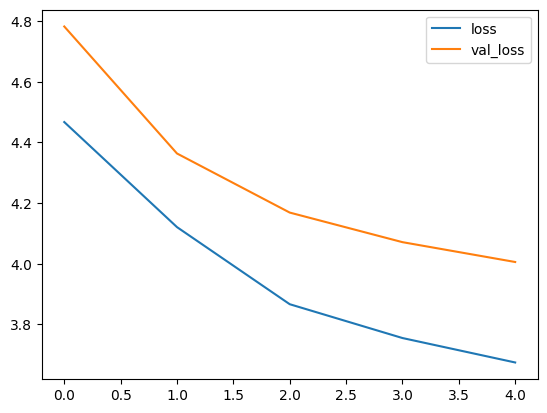

In [19]:
import matplotlib.pyplot as plt
epochs = [i for i in range(EPOCHS)]

plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.show()

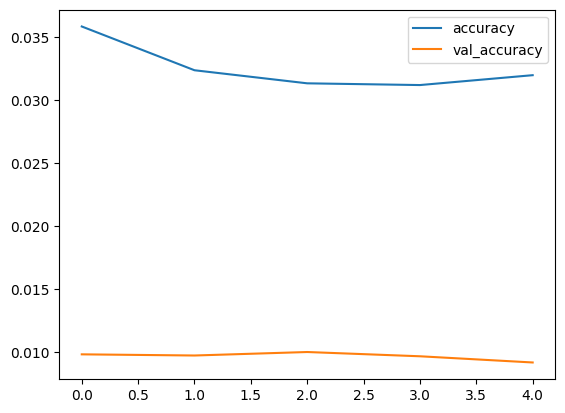

In [20]:
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.legend()
plt.show()

In [21]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  4160      
                                                                 
 conv2d_2 (Conv2D)           multiple                  110784    
                                                                 
 average_pooling2d (AverageP  multiple                 0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           multiple                  0  

 conv2d_36 (Conv2D)          multiple                  73872     
                                                                 
 conv2d_37 (Conv2D)          multiple                  373536    
                                                                 
 conv2d_38 (Conv2D)          multiple                  16416     
                                                                 
 conv2d_39 (Conv2D)          multiple                  51264     
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_40 (Conv2D)          multiple                  32832     
                                                                 
 conv2d_41 (Conv2D)          multiple                  135424    
                                                                 
 conv2d_42

In [ ]:
model.save('models/GoogleNet/model')